In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict

In [2]:
digits = load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [3]:
data = digits.data
images = digits.images
target = digits.target
target_names = digits.target_names

In [4]:
is_3_or_9 = np.isin(target, [3, 9])

data = data[is_3_or_9]
images = images[is_3_or_9]
target = target[is_3_or_9]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=42)

In [6]:
N_PIXELS = 2
mean = X_train.mean(axis=0)
highest_deviation = X_train.std(axis=0).argsort()[N_PIXELS:]

means = [
    X_train[:, highest_deviation][y_train == 3].mean(axis=0) / X_train.max(),
    X_train[:, highest_deviation][y_train == 9].mean(axis=0) / X_train.max()
]

def reduce_dim(X):
    X_filtered = X[:, highest_deviation]
    feat_1 = X_filtered.dot(means[0])
    feat_2 = X_filtered.dot(means[1])
    return np.vstack([feat_1, feat_2]).transpose()

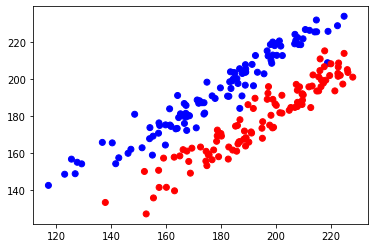

In [7]:
X_train_reduced = reduce_dim(X_train)
X_test_reduced = reduce_dim(X_test)

plt.scatter(*X_train_reduced.transpose(), c=["r" if x == 3 else "b" for x in y_train])
plt.show()

In [8]:
def iqr(X):
    return np.diff(np.quantile(X, q=[0.25, 0.75]))[0]
    
    
def freedman_diaconis_rule(X):
    return 2 * iqr(X) / np.cbrt(len(X))

In [9]:
def determine_bin_count(features_by_label):
    return int(np.ceil(np.mean([
                    np.ceil(
                        (feat.max(axis=0) - feat.min(axis=0)) / freedman_diaconis_rule(feat)) 
                    for feat in features_by_label])))

In [10]:
def fit_naive_bayes(features, labels, bincount=0):
    l1, l2 = np.unique(labels)[:, None] == labels

    if bincount <= 0:
        bincount = determine_bin_count([features[l1], features[l2]])
    
    histograms = np.array([
        np.apply_along_axis(lambda x: np.histogram(x, bincount, density=True)[0], arr=features[l1], axis=0).T,
        np.apply_along_axis(lambda x: np.histogram(x, bincount, density=True)[0], arr=features[l2], axis=0).T
    ])

    edges = np.array([
        np.apply_along_axis(lambda x: np.histogram_bin_edges(x, bincount), arr=features[l1], axis=0).T,
        np.apply_along_axis(lambda x: np.histogram_bin_edges(x, bincount), arr=features[l2], axis=0).T
    ])[:, :, :2]

    binning = np.dstack([edges[:, :, 0], edges[:, :, 1] - edges[:, :, 0]])
    
    return histograms, binning

In [11]:
def predict_naive_bayes(test_features, histograms, binning):
    N, D = test_features.shape
    C, D, L = histograms.shape
    
    p_j = np.empty((C, D, N))
    for k in range(C):
        bins = (np.floor((test_features - binning[k, :, 0])
                             / binning[k, : , 1])).astype(int)
        
        # calculation of bins can somehow result in a outside of [0, L] which needs to be capped
        bins = np.maximum(np.minimum(bins, L - 1), 0)
        p_j[k] = np.array([hist[bin] for hist, bin in zip(histograms[k], bins.T)])

    return np.log(p_j).sum(axis=1).argmax(axis=0)

/tmp/ipykernel_356268/853429751.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(p_j).sum(axis=1).argmax(axis=0)


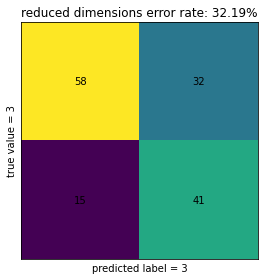

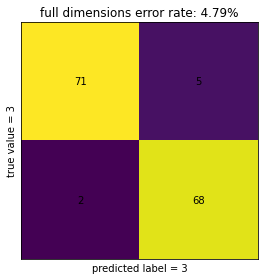

In [12]:
def error_rate(prediction, actual):
    return sum(prediction != actual)/ len(actual)

def confusion_matrix(predictions, real):
    return np.array([
        [sum(predictions[real == 3] == 3), sum(predictions[real == 9] == 3)],
        [sum(predictions[real == 3] == 9), sum(predictions[real == 9] == 9)]
    ])

def plot_confusion_matrix(predictions, real, title):
    conf_mat = confusion_matrix(predictions, real)
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat)
    ax.set_ylabel("true value = 3")
    ax.set_xlabel("predicted label = 3")
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
 
    # Loop over data dimensions and create text annotations.
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, conf_mat[i, j],
                           ha="center", va="center", color="black")

    ax.set_title(f"{title} error rate: {100 * error_rate(predictions, y_test):.2f}%")
    fig.tight_layout()

histograms, binning = fit_naive_bayes(X_train_reduced, y_train)
predictions = predict_naive_bayes(X_test_reduced, histograms, binning)  * 6 + 3
plot_confusion_matrix(predictions, y_test, "reduced dimensions")

histograms, binning = fit_naive_bayes(X_train, y_train)
predictions = predict_naive_bayes(X_test, histograms, binning)  * 6 + 3
plot_confusion_matrix(predictions, y_test, "full dimensions")
plt.show()

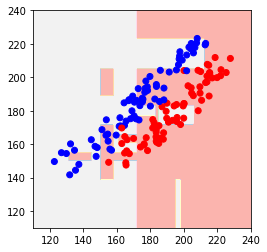

In [13]:
range_start = 110
range_end = 240
range_len = range_end - range_start

grid = np.array([[y, x] for x in range(range_start, range_end) for y in range(range_start, range_end)])

histograms, binning = fit_naive_bayes(X_train_reduced, y_train)
predictions = predict_naive_bayes(grid, histograms, binning).reshape(range_len, range_len)

plt.imshow(predictions, origin="lower", extent=[range_start, range_end, range_start, range_end], cmap="Pastel1")
plt.scatter(*X_test_reduced.transpose(), c=["r" if x == 3 else "b" for x in y_test])
plt.show()